<a href="https://colab.research.google.com/github/gaegoori/handsignproject/blob/model2/%EA%B8%B0%ED%95%99%EA%B8%B0_BiLSTM%EB%AA%A8%EB%8D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Drive 마운트
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%%bash
SRC="/content/drive/MyDrive/keypoints_all"
DST="/content/drive/MyDrive/keypoints_160F"

mkdir -p "$DST"

echo "정확한 WORD0001~0160 + REAL01~16 + F 버전만 추출 시작"

for z in "$SRC"/*.zip; do
    echo "ZIP 처리 중: $z"

    # 정확한 숫자 범위만 포함 (0001~0160)
    for i in $(seq -f "%04g" 1 160); do
        unzip -qq "$z" "*/NIA_SL_WORD${i}_REAL*_F*" -d "$DST"
    done
done

echo "추출 완료"
echo "저장 위치: $DST"

Process is terminated.


In [ ]:
import os
from zipfile import ZipFile

zip_path = "/content/drive/MyDrive/01_real_word_morpheme.zip"   # 네가 업로드한 경로
extract_to = "/content/drive/MyDrive/morpheme_full"

os.makedirs(extract_to, exist_ok=True)

with ZipFile(zip_path, 'r') as zf:
    zf.extractall(extract_to)

print("압축해제 완료:", extract_to)

압축해제 완료: /content/drive/MyDrive/morpheme_full


In [ ]:
import os, json, glob
from tqdm import tqdm

# 0. 경로 설정
# Keypoint 폴더의 루트 경로
keypoint_root = "/content/drive/MyDrive/keypoints_160F"
# Morpheme 파일의 루트 경로
morpheme_root = "/content/drive/MyDrive/morpheme_full/morpheme"
# 최종 JSON 파일이 저장될 경로
output_dir = "/content/drive/MyDrive/sign_data/fast_index"

os.makedirs(output_dir, exist_ok=True)

# ============================
# 1. WORD 0001 ~ 0160 자동 생성
# ============================
selected_words = {f"NIA_SL_WORD{str(i).zfill(4)}" for i in range(1, 161)}
print(f"선택된 단어 수: {len(selected_words)}개 (160개면 정상)")


# ============================
# 2. morpheme 파일 로드 및 REAL ID 딕셔너리 생성
# (NIA_SL_WORD0001_REAL02 → 파일 경로)
# ============================
morpheme_files = glob.glob(os.path.join(morpheme_root, "**/*.json"), recursive=True)
morpheme_dict = {}

def extract_real_id_from_morpheme(filename):
    # NIA_SL_WORD0001_REAL02_morpheme.json → NIA_SL_WORD0001_REAL02 추출
    name = os.path.basename(filename).replace("_morpheme.json", "")
    return name.rsplit("_", 1)[0]

for f in tqdm(morpheme_files, desc="Morpheme 파일 로드"):
    real_id = extract_real_id_from_morpheme(f)
    base_word = real_id.split("_REAL")[0] # NIA_SL_WORD0001

    # 선택된 단어에 포함되는 경우에만 딕셔너리에 추가
    if base_word in selected_words:
        # REAL ID를 고유 키로 사용하여 1:1 매칭 준비
        morpheme_dict[real_id] = f

print(f"필터링된 morpheme (REAL ID 기준) 개수: {len(morpheme_dict)}개")


# ============================
# 3. keypoint 폴더 로드 (F 버전만)
# ============================
keypoint_dirs = []

for root, dirs, files in os.walk(keypoint_root):
    for d in dirs:
        # 예: NIA_SL_WORD0001_REAL03_F 형식의 폴더만 선택
        if d.startswith("NIA_SL_WORD") and "_REAL" in d and d.endswith("_F"):
            keypoint_dirs.append(os.path.join(root, d))

print(f"선택된 keypoint 폴더 수: {len(keypoint_dirs)}개")


def extract_real_id_from_kp(folder_name):
    # NIA_SL_WORD0001_REAL03_F → NIA_SL_WORD0001_REAL03 추출
    return folder_name.rsplit("_", 1)[0]


# ============================
# 4. keypoint ↔ morpheme 1:1 매칭 및 fast_index 생성
# ============================
fast_index = []

for kp_path in tqdm(keypoint_dirs, desc="단어 매칭 중"):
    folder_name = os.path.basename(kp_path)

    # 1:1 매칭을 위한 REAL ID 추출
    real_id = extract_real_id_from_kp(folder_name)

    # base_word 추출 (선택된 단어 확인용)
    base_word = real_id.split("_REAL")[0]

    # base_word가 선택 목록에 있고, 해당 REAL ID의 morpheme 파일이 morpheme_dict에 있는 경우 매칭
    if base_word in selected_words and real_id in morpheme_dict:
        morpheme_path = morpheme_dict[real_id]

        fast_index.append({
            "word_id": base_word,
            "real_id": real_id, # 매칭된 고유 ID
            "keypoint_path": kp_path,
            "morpheme_path": morpheme_path
        })

print(f"최종 매칭된 데이터 개수: {len(fast_index)}개")


# ============================
# 5. JSON 저장
# ============================
output_path = os.path.join(output_dir, "fast_match.json")
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(fast_index, f, indent=4, ensure_ascii=False)

print("\n 저장 완료:", output_path)

선택된 단어 수: 160개 (160개면 정상)


Morpheme 파일 로드: 100%|██████████| 159672/159672 [00:00<00:00, 353926.36it/s]


필터링된 morpheme (REAL ID 기준) 개수: 1760개
선택된 keypoint 폴더 수: 2560개


단어 매칭 중: 100%|██████████| 2560/2560 [00:00<00:00, 105017.59it/s]

최종 매칭된 데이터 개수: 1760개

 저장 완료: /content/drive/MyDrive/sign_data/fast_index/fast_match.json


In [ ]:
!pip install ujson

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 3.7 MB/s eta 0:00:00


In [ ]:
import os, json, ujson, numpy as np
from tqdm import tqdm
from multiprocessing import Pool, cpu_count

# ============================
# 0. 경로 설정
# ============================
# 입력 파일: 이전 단계에서 생성된 1:1 매칭 인덱스 파일
fast_index_path = "/content/drive/MyDrive/fast_match.json"
# 출력 파일: Keypoint와 형태소 정보를 결합한 최종 데이터셋
output_path = "/content/drive/MyDrive/sign_data/processed/merged_dataset.json"

os.makedirs(os.path.dirname(output_path), exist_ok=True)

# 매칭 인덱스 로드
try:
    with open(fast_index_path, "r", encoding="utf-8") as f:
        pairs = json.load(f)
except FileNotFoundError:
    print(f"오류: fast_index 파일이 경로에 없습니다. 경로를 확인해주세요: {fast_index_path}")
    pairs = []
except Exception as e:
    print(f"오류: fast_index 파일 로드 중 예외 발생: {e}")
    pairs = []

print(f"처리할 매칭 쌍 개수: {len(pairs)}개")


# ============================
# 1. Keypoint 데이터 로드 및 정제 함수
# ============================
def load_person_data(fp):
    """프레임 하나 빠르게 읽고 (N, 3) Keypoint 배열 반환"""
    try:
        # ujson으로 파일 빠르게 로드
        with open(fp, "r") as f:
            kf = ujson.load(f)
    except:
        return None

    # 'people' 데이터 추출 및 형식 통일
    people = kf.get("people", [])
    if isinstance(people, dict):
        people = [people.get("0", people)]

    if not people:
        return None

    person = people[0]

    def safe_array(key):
        """키포인트를 안전하게 로드하고 (N, 3) 형태로 변환"""
        arr = person.get(key, [])
        if not arr:
            # 데이터가 없는 경우 (0, 3) 배열 반환
            return np.zeros((0, 3), dtype=np.float32)

        arr = np.array(arr, dtype=np.float32)
        # 2D 키포인트는 (N*3,) 형태이므로 (N, 3)으로 재구성
        return arr.reshape(-1, 3)

    # Keypoint 추출 및 연결 순서: Pose(25) + LeftHand(21) + RightHand(21) + Face(70) = 137 Keypoints
    p = safe_array("pose_keypoints_2d")
    lh = safe_array("hand_left_keypoints_2d")
    rh = safe_array("hand_right_keypoints_2d")
    face = safe_array("face_keypoints_2d")

    # 모든 키포인트 연결
    full = np.concatenate([p, lh, rh, face], axis=0)

    # 신뢰도(Confidence, 3번째 열)가 0.5 미만인 키포인트는 0으로 설정
    full[full[:, 2] < 0.5] = 0

    return full


# ============================
# 2. 병렬 처리 함수
# ============================
def process_item(item):
    """단어 1개의 Keypoint와 Morpheme을 결합하여 프레임 시퀀스 생성"""
    keypoint_dir = item["keypoint_path"]
    morpheme_path = item["morpheme_path"]
    fps = 30 # 초당 프레임 수 (NIA 수어 데이터셋 표준)
    real_id = item.get("real_id", "N/A") # real_id 가져오기

    # Morpheme 로드
    try:
        with open(morpheme_path, "r", encoding="utf-8") as f:
            mor = ujson.load(f)
        segments = mor.get("data", [])
        if not isinstance(segments, list):
             segments = [segments]
    except Exception:
        # print(f"Morpheme 로드 오류: {morpheme_path}")
        return []

    # Keypoint 프레임 파일 목록
    frame_files = sorted([
        os.path.join(keypoint_dir, f)
        for f in os.listdir(keypoint_dir)
        if f.endswith(".json")
    ])

    if not frame_files:
        return []

    # 모든 프레임 데이터 로드
    frames = []
    for fp in frame_files:
        full = load_person_data(fp)
        # 키포인트 개수 확인 (137개 = 25+21+21+70)
        if full is not None and full.shape[0] == 137:
            frames.append(full)

    if not frames:
        return []

    frames = np.stack(frames).astype(np.float32)
    results = []

    # 형태소 구간별 잘라서 저장
    for seg in segments:
        try:
            start_idx = int(seg["start"] * fps)
            end_idx = int(seg["end"] * fps)

            # 유효성 검사
            if start_idx >= len(frames) or end_idx <= start_idx:
                continue

            # 프레임 자르기
            cut = frames[start_idx:min(end_idx, len(frames))]

            results.append({
                "word_id": item["word_id"],
                "real_id": real_id,
                "label": seg["attributes"], # 형태소 레이블
                "frames": cut.tolist() # 넘파이 배열을 리스트로 변환
            })
        except Exception:
             # print(f"세그먼트 처리 오류: {real_id} - {seg}")
             continue

    return results


# ============================
# 3. 단어 전체를 병렬 처리 및 데이터 병합
# ============================
merged_data = []
if pairs:
    # CPU 코어 수만큼 Pool 생성
    core_count = cpu_count()
    print(f"사용 가능한 CPU 코어 수: {core_count}")
    with Pool(core_count) as P:
        # imap_unordered를 사용하여 결과를 비동기적으로 가져옴
        for res in tqdm(P.imap_unordered(process_item, pairs), total=len(pairs), desc="데이터 결합 중"):
            merged_data.extend(res)

# ============================
# 4. JSON 저장 (ujson 사용)
# ============================
if merged_data:
    try:
        print("\n데이터를 JSON 파일로 저장 중...")
        with open(output_path, "w") as f:
            ujson.dump(merged_data, f)

        print("\n 완료")
        print(f"최종 저장된 형태소 세그먼트 개수: {len(merged_data)}개")
        print(f"경로: {output_path}")
    except Exception as e:
        print(f"저장 오류: {e}")
else:
    print("\n 처리된 데이터가 없어 저장하지 않습니다.")

처리할 매칭 쌍 개수: 1760개
사용 가능한 CPU 코어 수: 2


데이터 결합 중: 100%|██████████| 1760/1760 [00:00<00:00, 6355.25it/s]


 처리된 데이터가 없어 저장하지 않습니다.


In [ ]:
import numpy as np
import json
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1. 파일 로드
file_path = '/content/drive/MyDrive/merged_dataset.json'

print("데이터 로드...")
with open(file_path, 'r') as f:
    data_json = json.load(f)
print("로드 완료. 총 세그먼트 수:", len(data_json))


# 2. frames padding → raw_data 생성
keypoint_data_list = [item["frames"] for item in data_json]

print("padding 중...")
padded_data = pad_sequences(keypoint_data_list, padding='post', dtype='float32')
raw_data = np.array(padded_data)
print("raw_data shape:", raw_data.shape)   # (N, T, 137, 3)


# 3. 4D → (N,T,F) reshape
N, T, P, C = raw_data.shape
F = P * C
raw_flat = raw_data.reshape(N, T, F)
print("reshape 완료:", raw_flat.shape)


# 4. Mid-Hip(또는 중심점) 상대좌표 (x,y만 변환)
def apply_midhip_relative(raw):
    print("Mid-Hip 상대좌표 변환 중...")

    N, T, F = raw.shape
    num_points = F // 3

    arr = raw.reshape(N, T, num_points, 3)

    REF = 0  # 데이터에서 0번이 진짜 Mid-Hip이면 그대로 사용
    ref_xy = arr[:, :, REF, :2]      # (N,T,2)
    ref_xy = ref_xy[:, :, None, :]   # (N,T,1,2) → broadcast

    arr[:, :, :, :2] -= ref_xy       # x,y만 상대좌표

    return arr.reshape(N, T, F)

X_midhip = apply_midhip_relative(raw_flat)
print("Mid-Hip 완료:", X_midhip.shape)


# 5. 핵심 keypoint 선택 (49개 → 147차원)
#   - Pose: Neck, Shoulders, Elbows, Wrists (7개)
#   - Left Hand: 21개 모두
#   - Right Hand: 21개 모두
POSE_IDXS = [1,2,3,4,5,6,7]     # 7개
HAND_IDXS = list(range(21))     # 21개 (0~20)

def select_keypoints(frame_137x3):
    # frame_137x3 : (137, 3)
    pose = frame_137x3[:25]     # (25,3)
    lh   = frame_137x3[25:46]   # (21,3)
    rh   = frame_137x3[46:67]   # (21,3)

    selected = []

    # 상체 7개
    for idx in POSE_IDXS:
        selected.append(pose[idx])

    # Left hand 21개
    for idx in HAND_IDXS:
        selected.append(lh[idx])

    # Right hand 21개
    for idx in HAND_IDXS:
        selected.append(rh[idx])

    selected = np.array(selected)   # (49,3)
    return selected.reshape(-1)     # 49*3 = 147


def apply_keypoint_selection(X):
    print("핵심 keypoint 선택 중...")
    N, T, F = X.shape
    num_points = F // 3
    Xr = X.reshape(N, T, num_points, 3)

    # 49개 keypoint × 3 = 147
    X_new = np.zeros((N, T, 49 * 3), dtype=np.float32)

    for i in range(N):
        for t in range(T):
            X_new[i, t] = select_keypoints(Xr[i, t])

    print("완료:", X_new.shape)
    return X_new

X_selected = apply_keypoint_selection(X_midhip)


# ⭐⭐⭐ 강화된 interpolation (v2) ⭐⭐⭐
def interpolate_strong(frames, th=0.5):
    """
    frames: (T, F=147)
    v2 → forward fill + backward fill + segment linear interpolation
    """
    T, F = frames.shape
    P = F // 3
    arr = frames.reshape(T, P, 3)

    for p in range(P):  # 각 keypoint마다 처리
        conf = arr[:, p, 2]
        x = arr[:, p, 0]
        y = arr[:, p, 1]

        # ---- 1) forward fill ----
        for t in range(1, T):
            if conf[t] < th and conf[t-1] >= th:
                x[t] = x[t-1]
                y[t] = y[t-1]
                conf[t] = conf[t-1]

        # ---- 2) backward fill ----
        for t in range(T-2, -1, -1):
            if conf[t] < th and conf[t+1] >= th:
                x[t] = x[t+1]
                y[t] = y[t+1]
                conf[t] = conf[t+1]

        # ---- 3) segment-based interpolation ----
        low_idx = np.where(conf < th)[0]

        if len(low_idx) > 0:
            seg_starts = []
            seg_ends = []
            start = low_idx[0]
            prev = low_idx[0]

            for idx in low_idx[1:]:
                if idx != prev + 1:
                    seg_starts.append(start)
                    seg_ends.append(prev)
                    start = idx
                prev = idx
            seg_starts.append(start)
            seg_ends.append(prev)

            for s, e in zip(seg_starts, seg_ends):
                prev_t = s - 1
                next_t = e + 1
                if prev_t < 0 or next_t >= T:
                    continue

                for t in range(s, e+1):
                    ratio = (t - s + 1) / (e - s + 2)
                    x[t] = (1-ratio) * x[prev_t] + ratio * x[next_t]
                    y[t] = (1-ratio) * y[prev_t] + ratio * y[next_t]
                    conf[t] = max(conf[prev_t], conf[next_t])

        arr[:, p, 0] = x
        arr[:, p, 1] = y
        arr[:, p, 2] = conf

    return arr.reshape(T, F)


print("강화된 interpolation v2 적용 중...")
X_interp = np.zeros_like(X_selected)
for i in range(len(X_selected)):
    X_interp[i] = interpolate_strong(X_selected[i])
print("보간 완료:", X_interp.shape)


# 7. confidence 제거 (x,y만)
def remove_confidence(X):
    N, T, F = X.shape
    P = F // 3
    coords = X.reshape(N, T, P, 3)[:, :, :, :2]  # (N,T,P,2)
    return coords.reshape(N, T, P * 2)          # (N,T,98)

X_xy = remove_confidence(X_interp)
print("confidence 제거 완료:", X_xy.shape)   # (N, T, 98)


# 8. 단순 스케일링
X_xy /= 1000.0


# 9. Train/Test split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

labels_text = np.array([item["label"][0]["name"] for item in data_json])
encoder = LabelEncoder()
y = encoder.fit_transform(labels_text)

X_train, X_test, y_train, y_test = train_test_split(
    X_xy, y,
    test_size=0.2,
    shuffle=True,
    random_state=42
)

print("Train:", X_train.shape)   # (N_train, 106, 98)
print("Test :", X_test.shape)    # (N_test, 106, 98)

print("전처리 파이프라인 완료 v")


데이터 로드...
로드 완료. 총 세그먼트 수: 1757
padding 중...
raw_data shape: (1757, 106, 137, 3)
reshape 완료: (1757, 106, 411)
Mid-Hip 상대좌표 변환 중...
Mid-Hip 완료: (1757, 106, 411)
핵심 keypoint 선택 중...
완료: (1757, 106, 147)
강화된 interpolation v2 적용 중...
보간 완료: (1757, 106, 147)
confidence 제거 완료: (1757, 106, 98)
Train: (1405, 106, 98)
Test : (352, 106, 98)
전처리 파이프라인 완료 v


In [ ]:
# 좌표 정규화
max_x = X_xy[..., 0::2].max()
max_y = X_xy[..., 1::2].max()

def normalize_xy(X):
    Xn = X.copy()
    Xn[..., 0::2] /= max_x
    Xn[..., 1::2] /= max_y
    return Xn

In [ ]:
X_train_norm = normalize_xy(X_train)
X_test_norm  = normalize_xy(X_test)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

def build_lstm_model(time_steps=106, feature_dim=98, num_classes=163):

    inputs = layers.Input(shape=(time_steps, feature_dim))

    # (1) Masking
    x = layers.Masking(mask_value=0.0)(inputs)

    # (2) Bi-LSTM
    x = layers.Bidirectional(
        layers.LSTM(128, return_sequences=True)
    )(x)

    # (3) Self-Attention
    attn_output = layers.MultiHeadAttention(
        num_heads=4,
        key_dim=64
    )(x, x)

    # (4) Residual + LayerNorm
    x = layers.LayerNormalization()(x + attn_output)

    # (5) Second BiLSTM (no return_sequences)
    x = layers.Bidirectional(
        layers.LSTM(128)
    )(x)

    # (6) Dense layers
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

es = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model = build_lstm_model()
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 106, 98)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_3         │ (None, 106, 98)   │          0 │ input_layer_3[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_3 (Masking) │ (None, 106, 98)   │          0 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_3 (Any)         │ (None, 106)       │          0 │ not_equal_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_6     │ (None, 106, 256)  │    232,448 │ masking_3[0][0],  │
│ (Bidirectional)     │                   │            │ any_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 106, 256)  │    263,168 │ bidirectional_6[… │
│ (MultiHeadAttentio… │                   │            │ bidirectional_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 106, 256)  │          0 │ bidirectional_6[… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 106, 256)  │        512 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_7     │ (None, 256)       │    394,240 │ layer_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 256)       │     65,792 │ bidirectional_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 256)       │          0 │ dense_9[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 128)       │     32,896 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 128)       │          0 │ dense_10[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 163)       │     21,027 │ dropout_11[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,010,083 (3.85 MB)

 Trainable params: 1,010,083 (3.85 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train_norm, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    callbacks=[es],
    verbose=1
)

Epoch 1/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - accuracy: 0.0035 - loss: 5.1551 - val_accuracy: 0.0071 - val_loss: 5.0900
Epoch 2/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.0054 - loss: 5.1095 - val_accuracy: 0.0107 - val_loss: 5.0923
Epoch 3/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.0083 - loss: 5.0838 - val_accuracy: 0.0178 - val_loss: 5.0670
Epoch 4/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.0171 - loss: 5.0499 - val_accuracy: 0.0107 - val_loss: 5.0333
Epoch 5/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.0146 - loss: 5.0245 - val_accuracy: 0.0178 - val_loss: 4.9762
Epoch 6/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.0161 - loss: 4.9487 - val_accuracy: 0.0249 - val_loss: 4.9295
Epoch 7/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.0311 - loss: 4.8775 - val_accuracy: 0.0356 - val_loss: 4.8519
Epoch 8/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.0407 - loss: 4.7855 - val_accuracy: 0.

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print("Test Loss :", test_loss)
print("Test Acc  :", test_acc*100)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4861 - loss: 2.9444
Test Loss : 2.9558870792388916
Test Acc  : 45.17045319080353


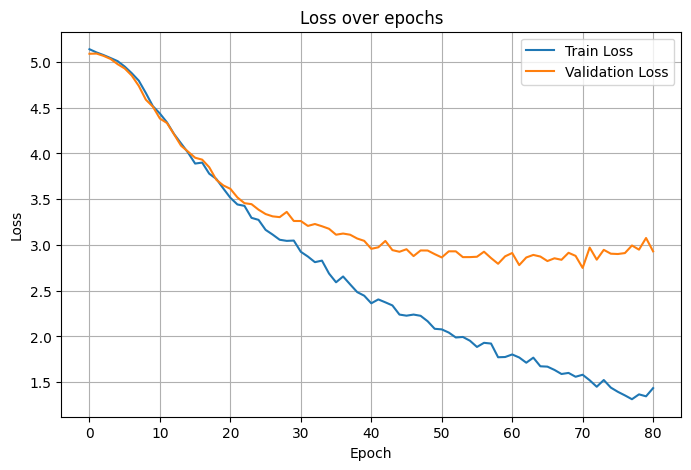

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()